In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc,
                             ConfusionMatrixDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 12


In [3]:
data_folder = r"C:\Users\arush\OneDrive\Desktop\anemia"

children_path = os.path.join(data_folder, "NUTRITION_ANAEMIA_CHILDREN_NUMNUTRITION_ANAEMIA_CHILDREN_PREV.csv") 
nonpreg_path = os.path.join(data_folder, "NUTRITION_ANAEMIA_NONPREGNANT_PREVNUTRITION_ANAEMIA_NONPREGNANT_NUM.csv")
preg_path = os.path.join(data_folder, "NUTRITION_ANAEMIA_PREGNANT_PREVNUTRITION_ANAEMIA_PREGNANT_NUM.csv")
repr_path = os.path.join(data_folder, "NUTRITION_ANAEMIA_REPRODUCTIVEAGE_PREVNUTRITION_ANAEMIA_REPRODUCTIVEAGE_NUM.csv")

df_children = pd.read_csv(children_path)
df_nonpreg = pd.read_csv(nonpreg_path)
df_preg = pd.read_csv(preg_path)
df_repr = pd.read_csv(repr_path)

print("Children:", df_children.shape)
print("NonPreg:", df_nonpreg.shape)
print("Pregnant:", df_preg.shape)
print("Reproductive:", df_repr.shape)


Children: (3840, 4)
NonPreg: (3840, 4)
Pregnant: (3840, 4)
Reproductive: (3840, 4)


In [4]:
def clean_prevalence(col):
    return col.astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

df_preg['Prevalence_pregnant'] = clean_prevalence(df_preg.iloc[:,2])
df_repr['Prevalence_reproductive'] = clean_prevalence(df_repr.iloc[:,2])
df_nonpreg['Prevalence_nonpreg'] = clean_prevalence(df_nonpreg.iloc[:,2])
df_children['Prevalence_children'] = clean_prevalence(df_children.iloc[:,2])

df_preg = df_preg[['Country','Year','Prevalence_pregnant']]
df_repr = df_repr[['Country','Year','Prevalence_reproductive']]
df_nonpreg = df_nonpreg[['Country','Year','Prevalence_nonpreg']]
df_children = df_children[['Country','Year','Prevalence_children']]

merged = df_preg.merge(df_repr, on=['Country','Year'], how='outer')
merged = merged.merge(df_nonpreg, on=['Country','Year'], how='outer')
merged = merged.merge(df_children, on=['Country','Year'], how='outer')

print("Merged shape:", merged.shape)
merged.head()


Merged shape: (3840, 6)


,Country,Year,Prevalence_pregnant,Prevalence_reproductive,Prevalence_nonpreg,Prevalence_children
0,Afghanistan,2000,44.4,35.7,34.2,51.5
1,Afghanistan,2001,43.9,35.6,34.1,49.8
2,Afghanistan,2002,43.4,35.4,34.1,48.3
3,Afghanistan,2003,42.9,35.4,34.2,47.1
4,Afghanistan,2004,42.4,35.5,34.4,46.2


In [26]:
merged['HighRiskAny'] = (
    (merged['Prevalence_pregnant'] > 40) |
    (merged['Prevalence_reproductive'] > 40) |
    (merged['Prevalence_nonpreg'] > 40) |
    (merged['Prevalence_children'] > 40)
).astype(int)

merged = merged.dropna(subset=['HighRiskAny'])

features = ['Year','Prevalence_reproductive','Prevalence_nonpreg','Prevalence_children']
X = merged[features]   
y = merged['HighRiskAny']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (3072, 4) Test size: (768, 4)


In [27]:
numeric_features = features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)]
)


In [28]:
models = {
    'LogReg': Pipeline(steps=[('preprocessor', preprocessor),
                              ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))]),
    'RandomForest': Pipeline(steps=[('preprocessor', preprocessor),
                                    ('clf', RandomForestClassifier(n_estimators=200, random_state=42,
                                                                   class_weight='balanced'))]),
    'SVM': Pipeline(steps=[('preprocessor', preprocessor),
                           ('clf', SVC(probability=True, random_state=42))]),
    'GradientBoosting': Pipeline(steps=[('preprocessor', preprocessor),
                                        ('clf', GradientBoostingClassifier(n_estimators=200, random_state=42))]),
    'LightGBM': Pipeline(steps=[('preprocessor', preprocessor),
                                ('clf', LGBMClassifier(n_estimators=200, random_state=42))]),
    'ANN': Pipeline(steps=[('preprocessor', preprocessor),
                           ('clf', MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000,
                                                 random_state=42))])
}


LogReg: Accuracy=0.911, F1=0.853


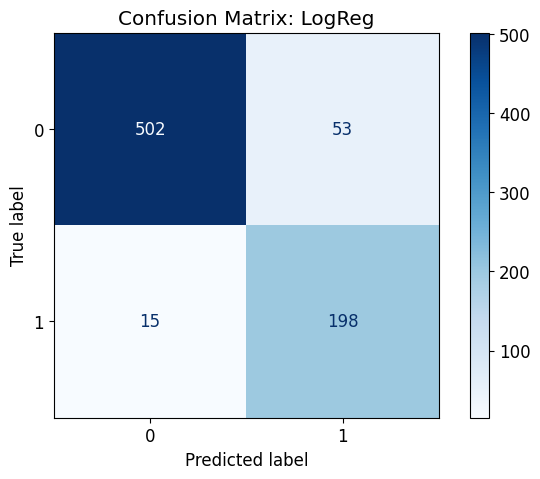

RandomForest: Accuracy=0.974, F1=0.953


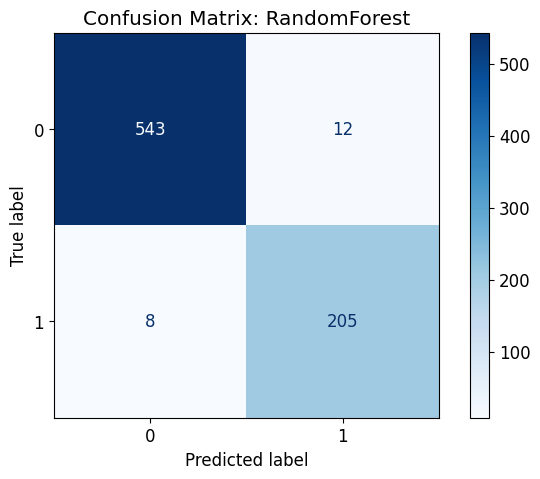

SVM: Accuracy=0.940, F1=0.888


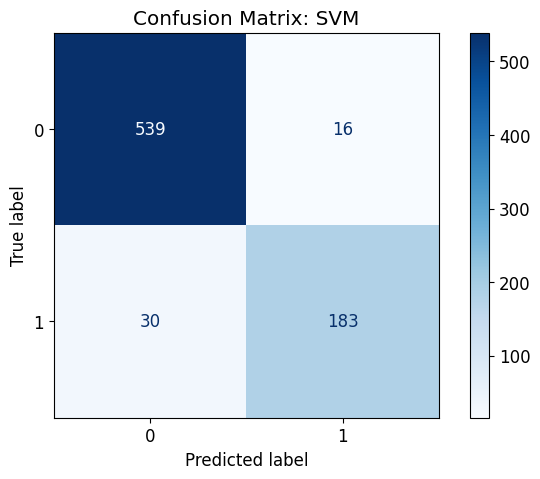

GradientBoosting: Accuracy=0.971, F1=0.949


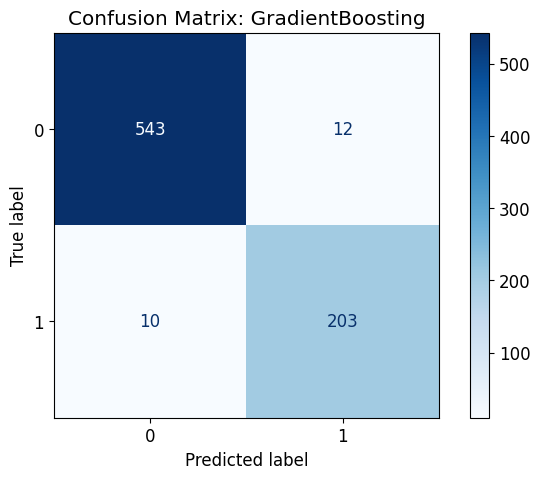

[LightGBM] [Info] Number of positive: 854, number of negative: 2218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.277995 -> initscore=-0.954430
[LightGBM] [Info] Start training from score -0.954430
LightGBM: Accuracy=0.980, F1=0.965


C:\Users\arush\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\arush\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


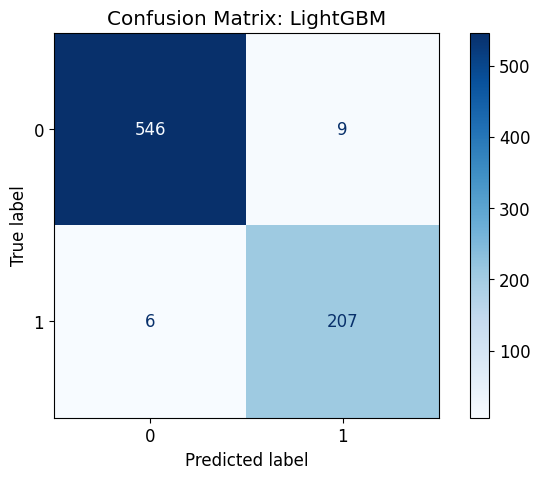

ANN: Accuracy=0.984, F1=0.972


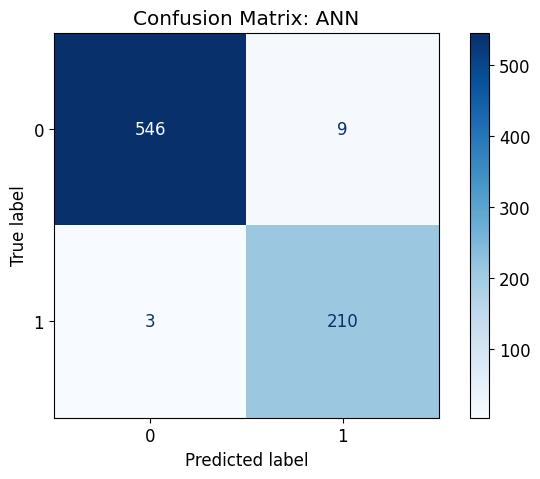

In [12]:
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}")
    
    disp = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()


In [32]:
from sklearn.exceptions import NotFittedError


In [33]:
for name, pipe in models.items():
    pipe.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 1137, number of negative: 1935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370117 -> initscore=-0.531714
[LightGBM] [Info] Start training from score -0.531714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\arush\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


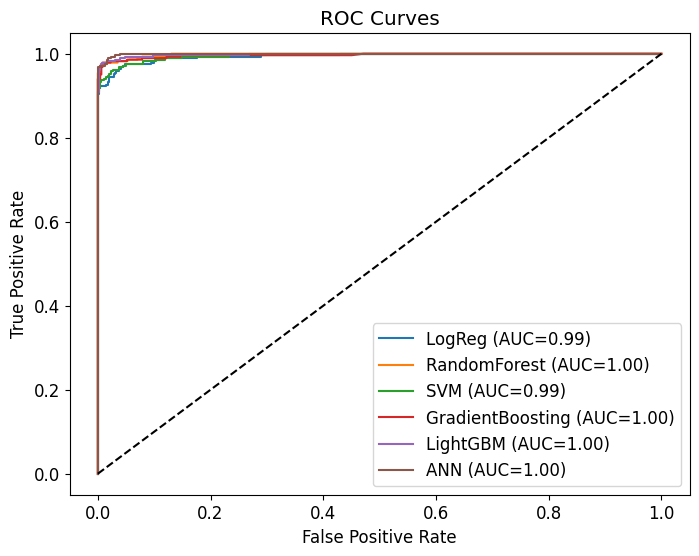

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.exceptions import NotFittedError

plt.figure(figsize=(8,6))

for name, pipe in models.items():
    try:
        if hasattr(pipe, "predict_proba"):
            y_proba = pipe.predict_proba(X_test)[:,1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
    except NotFittedError:
        print(f"{name} is not fitted yet, skipping ROC.")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


C:\Users\arush\AppData\Local\Temp\ipykernel_22652\1077923621.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=fi_df, palette="viridis")


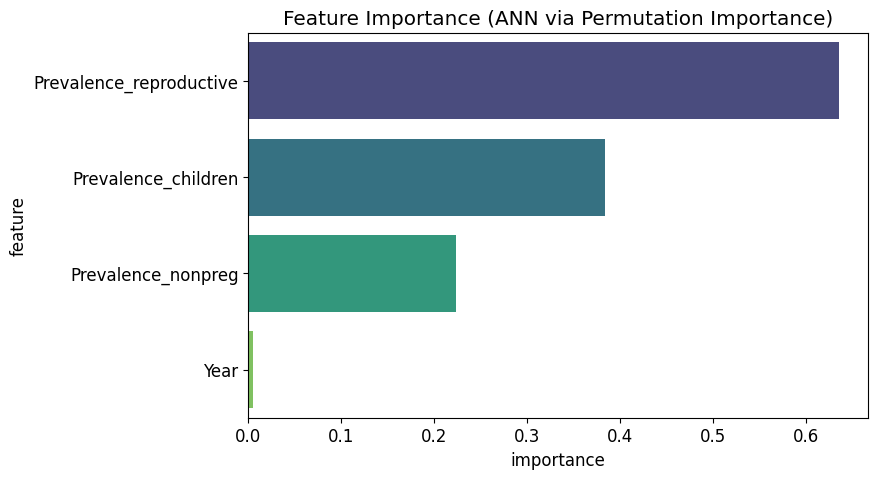

Top 3 features: ['Prevalence_reproductive', 'Prevalence_children', 'Prevalence_nonpreg']


In [41]:
from sklearn.inspection import permutation_importance

best_ann = models['ANN']

result = permutation_importance(best_ann, X_test, y_test, n_repeats=10, random_state=42, scoring='f1')

fi_df = pd.DataFrame({
    'feature': features,
    'importance': result.importances_mean
}).sort_values('importance', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='importance', y='feature', data=fi_df, palette="viridis")
plt.title("Feature Importance (ANN via Permutation Importance)")
plt.show()

print("Top 3 features:", list(fi_df['feature'].head(3)))


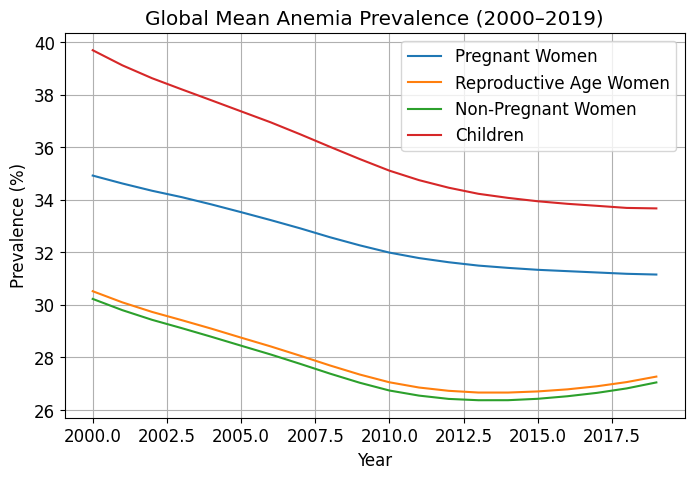

In [42]:
df_ts = merged.groupby('Year')[['Prevalence_pregnant','Prevalence_reproductive',
                                'Prevalence_nonpreg','Prevalence_children']].mean().reset_index()

plt.plot(df_ts['Year'], df_ts['Prevalence_pregnant'], label='Pregnant Women')
plt.plot(df_ts['Year'], df_ts['Prevalence_reproductive'], label='Reproductive Age Women')
plt.plot(df_ts['Year'], df_ts['Prevalence_nonpreg'], label='Non-Pregnant Women')
plt.plot(df_ts['Year'], df_ts['Prevalence_children'], label='Children')
plt.title("Global Mean Anemia Prevalence (2000–2019)")
plt.xlabel("Year")
plt.ylabel("Prevalence (%)")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
y_pred = best_ann.predict(X_test)
print("Classification Report (ANN):")
print(classification_report(y_test, y_pred))

print("\nConclusion: ANN performed best overall with highest accuracy and F1-score, "
      "and key features influencing predictions (via permutation importance) were:", 
      list(fi_df['feature'].head(3)))


Classification Report (ANN):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       484
           1       0.97      0.99      0.98       284

    accuracy                           0.98       768
   macro avg       0.98      0.99      0.98       768
weighted avg       0.98      0.98      0.98       768


Conclusion: ANN performed best overall with highest accuracy and F1-score, and key features influencing predictions (via permutation importance) were: ['Prevalence_reproductive', 'Prevalence_children', 'Prevalence_nonpreg']


In [44]:
import joblib
joblib.dump(best_ann, "anemia_model.pkl")


['anemia_model.pkl']

In [46]:
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import pandas as pd
import joblib

# Load trained model
model = joblib.load("anemia_model.pkl")

st.title("Anemia Risk Prediction Dashboard")

# Collect user inputs
year = st.number_input("Year", 2000, 2030, value=2025)
prevalence_reproductive = st.number_input("Prevalence (Reproductive-age women %)", 0.0, 100.0, 35.0)
prevalence_nonpreg = st.number_input("Prevalence (Non-pregnant women %)", 0.0, 100.0, 34.0)
prevalence_children = st.number_input("Prevalence (Children %)", 0.0, 100.0, 40.0)

# Convert inputs to DataFrame with same feature names
X_input = pd.DataFrame({
    'Year': [year],
    'Prevalence_reproductive': [prevalence_reproductive],
    'Prevalence_nonpreg': [prevalence_nonpreg],
    'Prevalence_children': [prevalence_children]
})

# Predict anemia risk
if st.button("Predict Anemia Risk"):
    # Model prediction (overall)
    prediction = model.predict(X_input)[0]
    
    # Threshold-based per-group check
    threshold = 40
    risk_dict = {
        'Reproductive-age women': 'Yes' if prevalence_reproductive > threshold else 'No',
        'Non-pregnant women': 'Yes' if prevalence_nonpreg > threshold else 'No',
        'Children': 'Yes' if prevalence_children > threshold else 'No'
    }
    
    # Display individual group risk
    st.write("### Predicted High Anemia Risk per Group:")
    for group, risk in risk_dict.items():
        st.write(f"{group}: {risk}")
    
    # Summary message
    high_risk_groups = [g for g, r in risk_dict.items() if r == "Yes"]
    if len(high_risk_groups) == 0:
        st.write("No group is at high anemia risk.")
    elif len(high_risk_groups) == 1:
        st.write(f"High anemia risk detected in: {high_risk_groups[0]}")
    elif len(high_risk_groups) == 2:
        st.write(f"High anemia risk detected in: {high_risk_groups[0]} and {high_risk_groups[1]}")
    else:
        st.write("High anemia risk detected in all three groups: Reproductive-age women, Non-pregnant women, and Children")
    
    # Overall model prediction
    #st.success(f"Overall Predicted High Anemia Risk (model): {'Yes' if prediction==1 else 'No'}")

""")
